In [96]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from glob import glob
from astropy.visualization import ZScaleInterval
import stdatamodels.jwst.datamodels as dm
from astropy.visualization import ZScaleInterval
from scipy.signal import find_peaks_cwt
from scipy.optimize import curve_fit as cfit

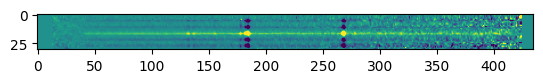

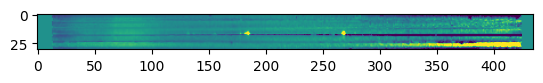

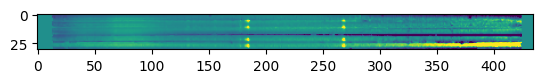

In [45]:
workingDir = "../mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/"
mastPath = workingDir + "Mast/jw01345-o063_s01699_nirspec_clear-prism_s2d.fits"
myPath = workingDir + "Final/jw01345-o063_s01699_nirspec_clear-prism_s2d.fits"

mastmos = dm.open(mastPath)
mastData = mastmos.data
    
mymos = dm.open(myPath)
myData = mymos.data
    
plt.figure()
z = ZScaleInterval()
z1, z2 = z.get_limits(mastData)
plt.imshow(mastData,vmin=z1,vmax=z2)
plt.show()

plt.figure()
z = ZScaleInterval()
z1, z2 = z.get_limits(myData)
plt.imshow(myData,vmin=z1,vmax=z2)
plt.show()

plt.figure()
res = myData - mastData
z = ZScaleInterval()
z1, z2 = z.get_limits(res)
plt.imshow(res,vmin=z1,vmax=z2)
plt.show()


In [14]:
with dm.open(workingDir+"jw01345063001_03101_00001_nrs1_srctype.fits") as src:
    slits = src.slits

In [78]:
def extract_spectrum(slit,label,lamb=None):
    plt.figure()
    z = ZScaleInterval()
    z1, z2 = z.get_limits(slit.data)
    plt.imshow(slit.data,vmin=z1,vmax=z2)

    if lamb is None:
        lamb = slit.wavelength

    n = 3
    s_dec, s_ra = slit.source_dec, slit.source_ra
    x, y = slit.meta.wcs.transform("world", "detector", s_ra, s_dec, 3)
    plt.hlines((y + n, y - n), 0, slit.data.shape[1], color='r', linewidth=0.5, linestyle='dashed')
    print(y)

    wavelength = lamb[round(y) - n:round(y) + n, :]
    target = slit.data[round(y) - n:round(y) + n, :]
    err = slit.err[round(y) - n:round(y) + n, :]


    wavelength = wavelength.mean(axis=0)
    spectrum = target.mean(axis=0)
    # Usually, the error is dominated by the variance on the slice
    err = np.mean(err ** 2, axis=0) + target.var(axis=0)
    err = np.sqrt(err)

    # The spectrum plot
    plt.figure()
    plt.errorbar(wavelength, spectrum, yerr=err, marker='.', linewidth=0.3,label=label)
    plt.grid(True)
    plt.show()
    
    return wavelength, spectrum, err

14.309998466964771


<Figure size 640x480 with 0 Axes>

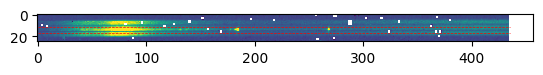

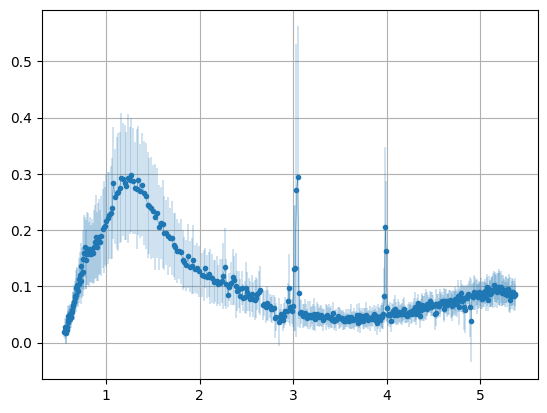

17.299729036440507


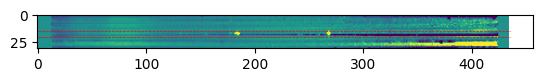

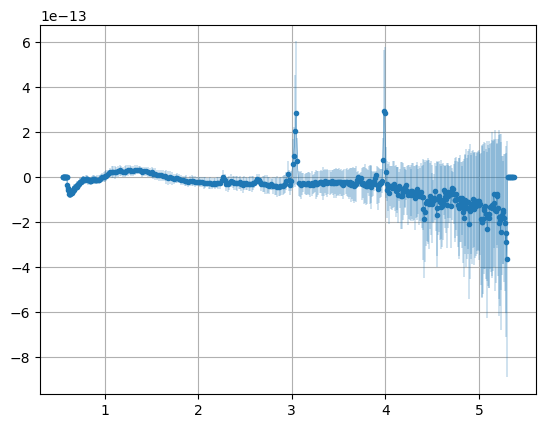

16.43027005296354


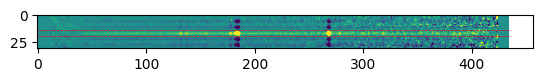

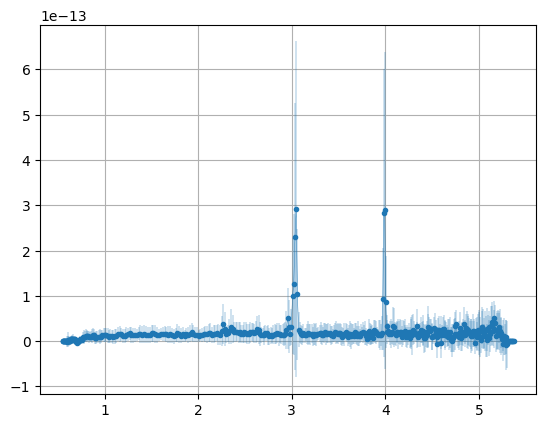

In [79]:
for slit in slits:
    if slit.name == "259":
        plt.figure()
        src_x, src_y, src_err = extract_spectrum(slit,"srctype")
        
        Y, X = np.indices(mymos.data.shape)
        ra, dec, lamb = mymos.meta.wcs.transform('detector', 'world', X, Y)
        my_x, my_y, my_err = extract_spectrum(mymos,"mydata",lamb=lamb)
        
        Y, X = np.indices(mastmos.data.shape)
        ra, dec, lamb = mastmos.meta.wcs.transform('detector', 'world', X, Y)
        mast_x, mast_y, mast_err = extract_spectrum(mastmos,"mast",lamb=lamb)


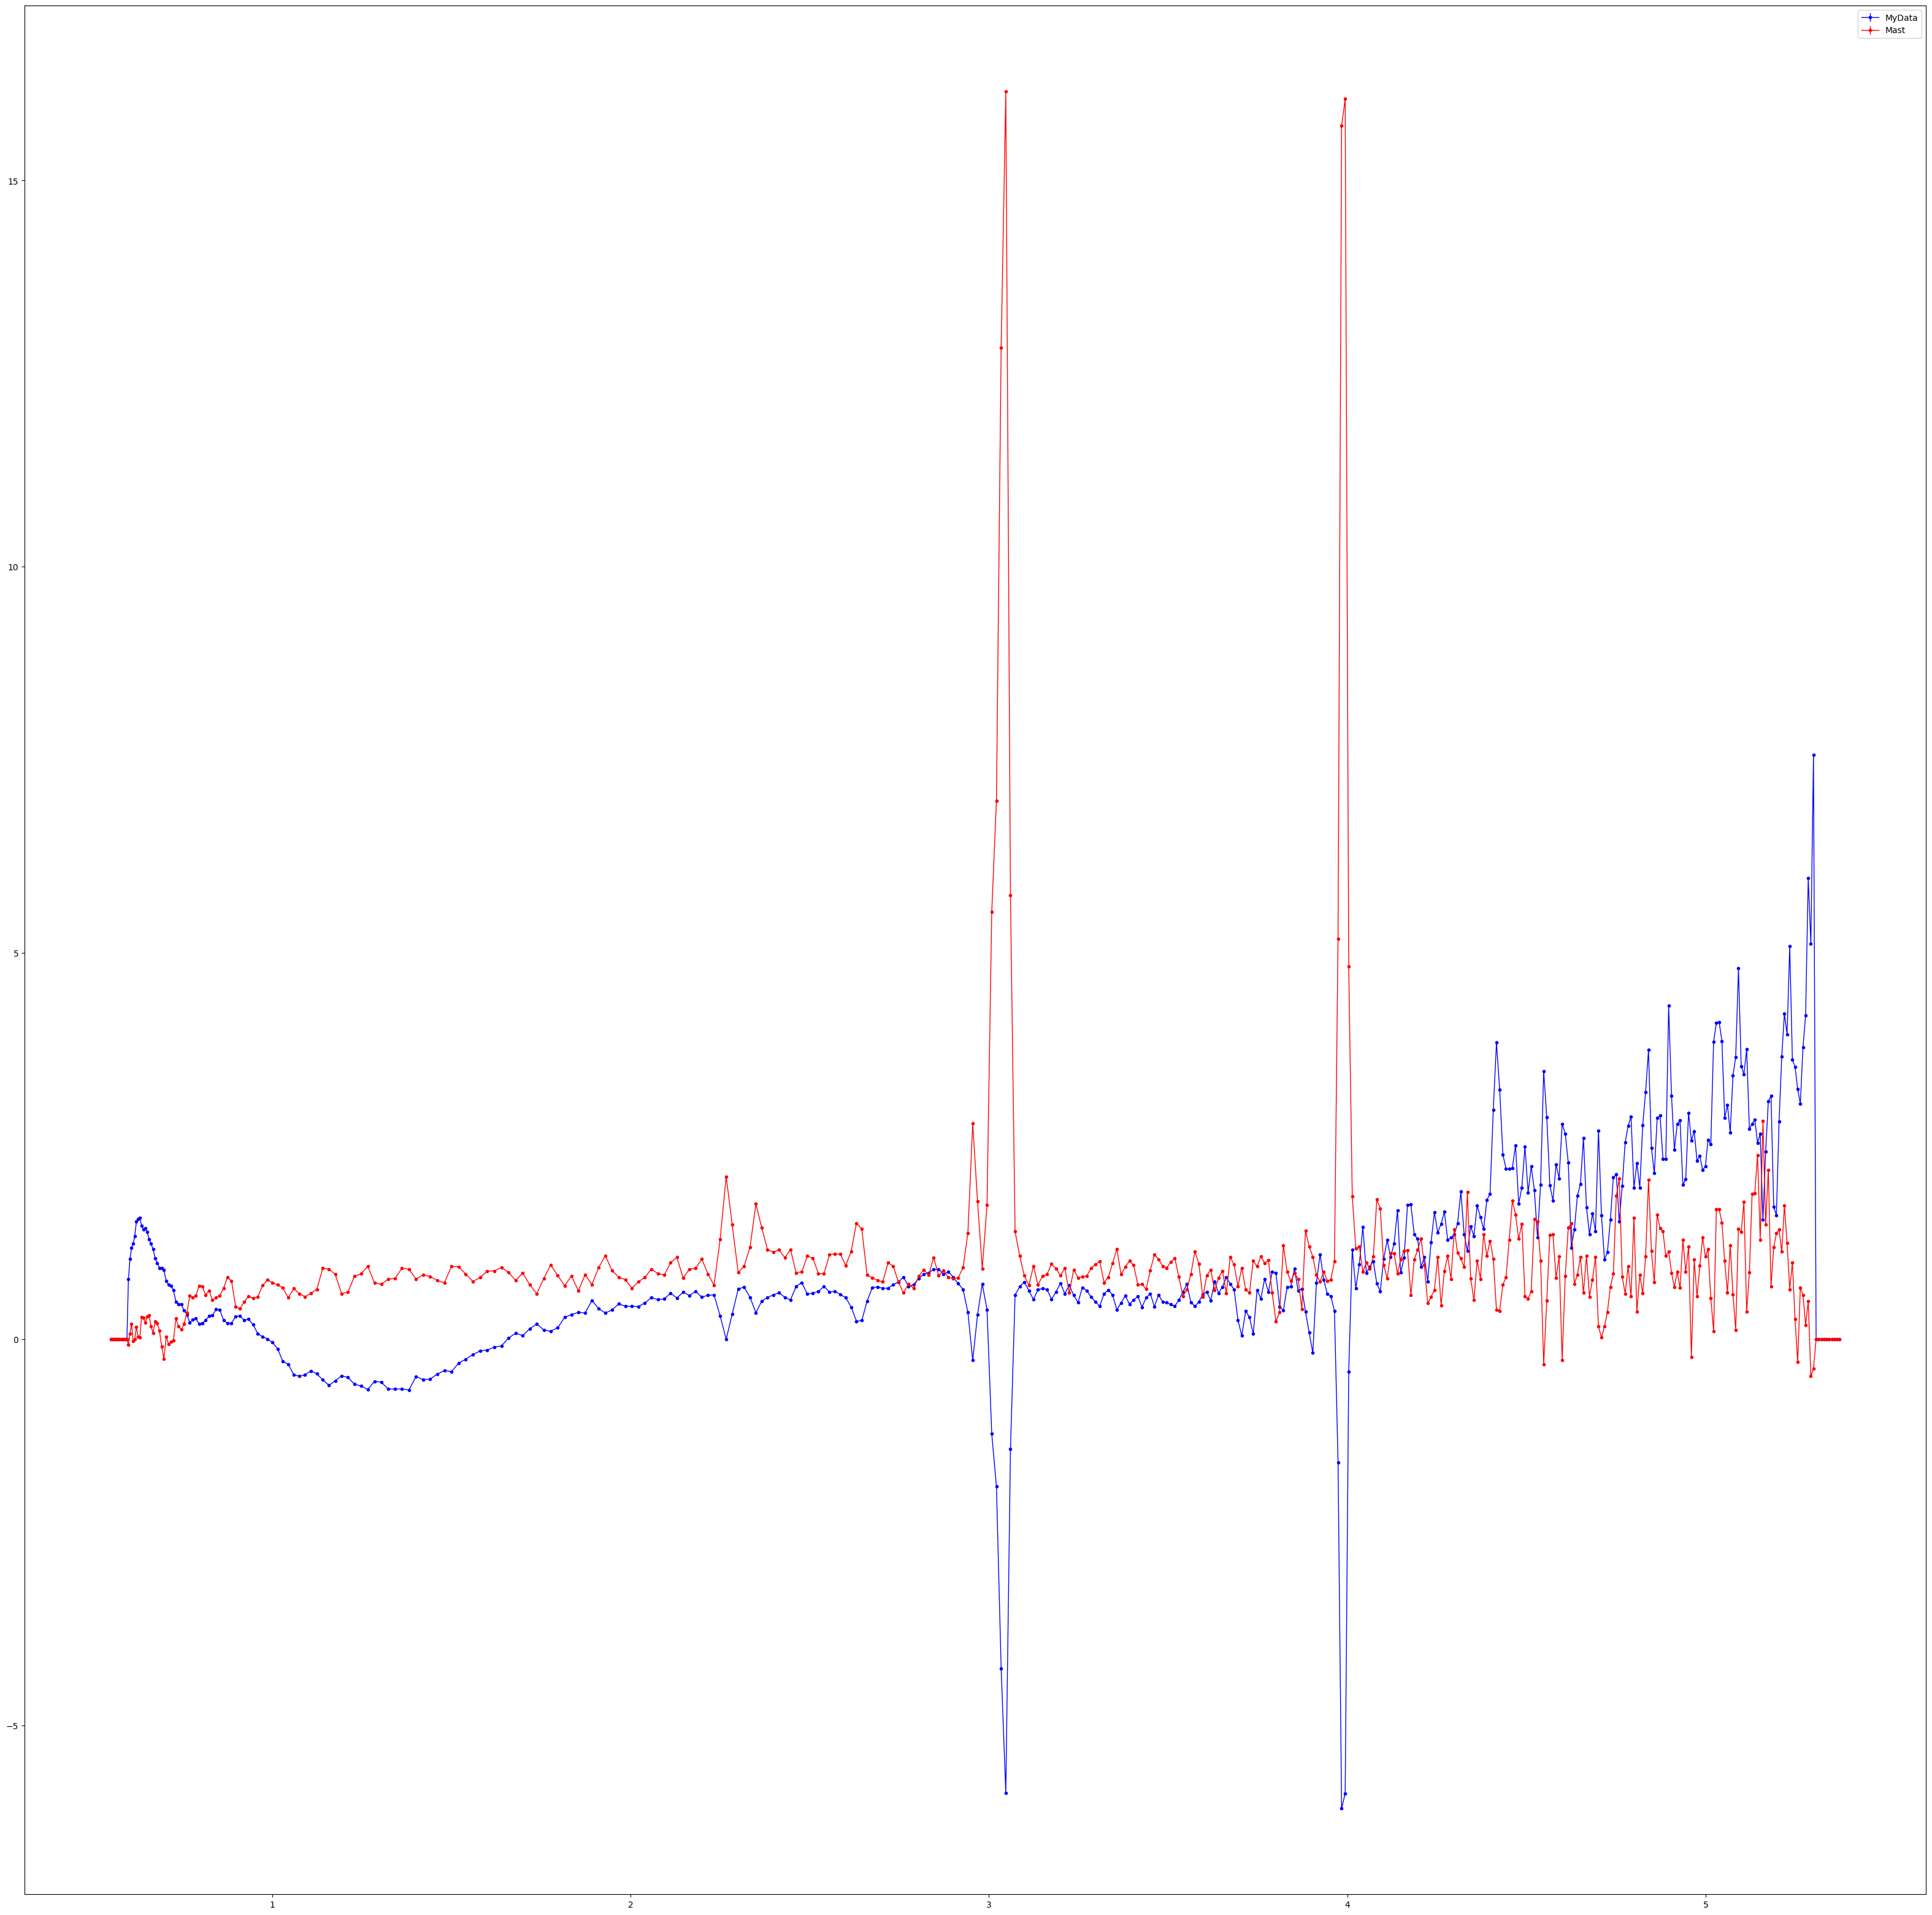

In [71]:
plt.figure(figsize=(40,40))
#plt.errorbar(src_x,src_y/src_y[~np.isnan(src_y)].mean(),yerr=src_err,color="k",marker='.',linewidth=1,label="Srctype")
plt.errorbar(my_x,my_y/my_y.mean(),yerr=my_err,color="b",marker='.',linewidth=1,label="MyData")
plt.errorbar(mast_x,mast_y/mast_y.mean(),yerr=mast_err,color="r",marker='.',linewidth=1,label="Mast")

plt.legend()
plt.show()

In [113]:
def gaussian(x,x0,A,s):
    """
    Simple gaussian function
    """
    return A * np.exp(-(x-x0)**2 / (2*s**2))

"""
Slitlet model : 3 gaussians of same sigma
"""
def slitletModel(x,x1,x2,x3,A1,A2,A3,s,c):
    return gaussian(x,x1,A1,s) + gaussian(x,x2,A2,s) + gaussian(x,x3,A3,s) + c

def smallest(x,y):
    if x < y:
        return x
    else:
        return y

1x1


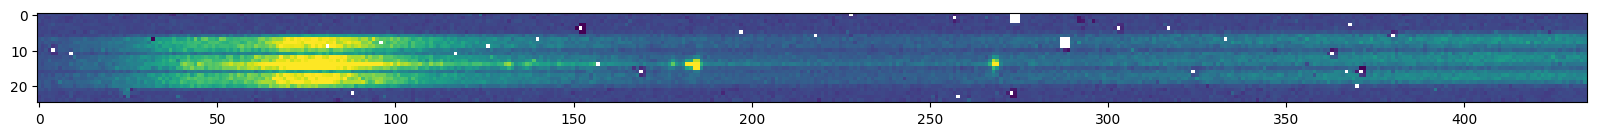

In [82]:
for slit in slits:
    if slit.name == "259":
        data = np.ma.masked_invalid(slit.data)
        print(slit.shutter_state)
plt.figure(figsize=(20,4))
z = ZScaleInterval()
z1, z2 = z.get_limits(data)
plt.imshow(data,vmin=z1,vmax=z2)
plt.show()

[ 8 14 19]
[ 7.99959712 13.07364154 17.7994426 ]
2.537022207545198 2.362900532802545
[[ 5 11]
 [11 15]
 [15 20]]


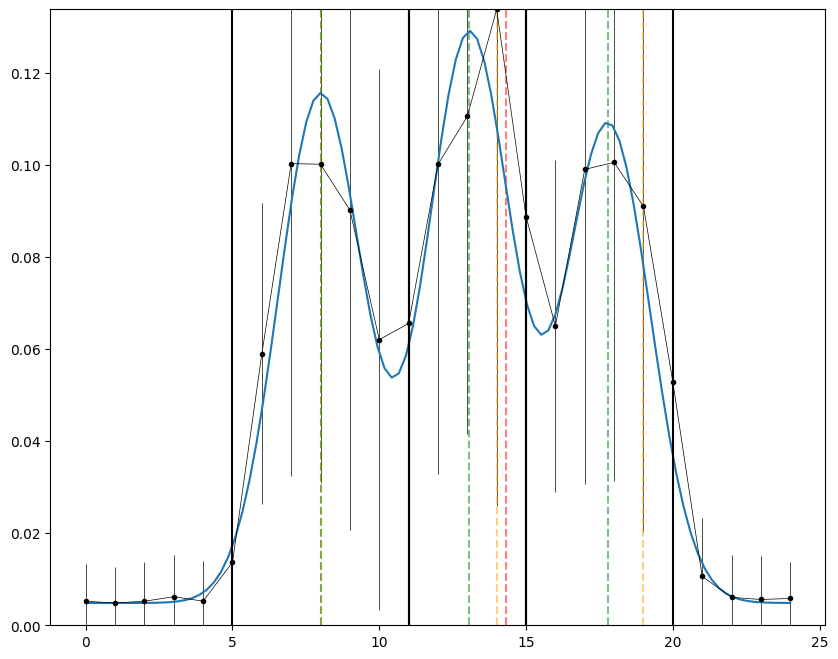

In [114]:
horiz_sum = np.mean(data,axis=1)
horiz_err = np.std(data,axis=1)
hmax = horiz_sum.max()
x = range(len(horiz_sum))

plt.figure(figsize=(10,8))
plt.ylim(0,hmax)
plt.errorbar(x,horiz_sum,yerr=horiz_err,color='k',marker='.',linewidth=0.5)
plt.vlines(14.3099,0,hmax,color='r',linestyle='dashed',alpha=0.5)

peaks = []
j = 2
while not len(peaks) == 3:
    if j > 6:
        break
    peaks = find_peaks_cwt(horiz_sum,j)
    j += 1

print(peaks)
plt.vlines(peaks,0,hmax,color='orange',linestyle="dashed",alpha=0.5)
    

coeff, err = cfit(slitletModel, x, horiz_sum, sigma=horiz_err, p0=[*peaks,*horiz_sum[peaks],0.5,0])
peaks = np.array(coeff[:3])
peaks = np.sort(peaks)

print(peaks)
plt.vlines(peaks,0,hmax,color='green',linestyle="dashed",alpha=0.5)

X = np.linspace(0,x[-1],100)
plt.plot(X,slitletModel(X,*coeff))

d1 = (peaks[1] - peaks[0])/2
d2 = (peaks[2] - peaks[1])/2

print(d1,d2)

xmin = np.array([round(max(0,peaks[0]-d1)),round(peaks[1]-d1),round(peaks[2]-d2)])
xmax = np.array([round(peaks[0]+d1), round(peaks[1]+d2), round(min(x[-1],peaks[2]+d2))])

slice_indices = np.array([xmin,xmax]).T
print(slice_indices)

plt.vlines(slice_indices.ravel(),0,hmax,color='k')



plt.show()